# Matching. Поиск наиболее похожих товаров

## 1. Подготовка данных

###  Загрузка библиотек и датасетов

In [49]:
!pip install --upgrade -q scikit-learn
!pip install -q faiss-cpu

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm import tqdm

import copy

import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile
import os.path

import faiss
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
zip_path = '/Users/lena/data.zip'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
     

if not os.path.exists(zip_path):
  download_response = requests.get(download_url)
  with open(zip_path, 'wb') as f:
    f.write(download_response.content)
     

# Распаковка zip-архива
if not os.path.exists('/Users/lena/base.csv'):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [51]:
base_data = pd.read_csv('/Users/lena/base.csv', index_col=0)
train_data = pd.read_csv('/Users/lena/train.csv', index_col=0)
valid_data = pd.read_csv('/Users/lena/validation.csv', index_col=0)
valid_answers_data = pd.read_csv('/Users/lena/validation_answer.csv', index_col=0)

### Загрузка файла с данными и предобработка данных

In [136]:
# Напишем функцию, выводящую общую информацию о датасетах, пропуски и явные дубликаты
def check_data(data, srtings=5):
    data.info()
    
    display(data.head(srtings))
    
    print('Количество пропусков:')
    print(data.isna().sum())
    print()ч
    
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    
    display(data.describe().T)

Изучим основную информацию о данных в датасете base_data

In [137]:
check_data(base_data)

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   

               63         64          65        66         67          68  \
Id                                                                          
0-base  38.800827 -151.76218  -74.389090  63.66634  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.20211  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.56618  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.20289 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.76632  -2.505783   65.315285   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  

[5 rows x 72 columns]

Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0



count        mean         std          min          25%          50%  \
0   2918139.0  -86.229474   24.891320  -199.468700  -103.065438   -86.231500   
1   2918139.0    8.080077    4.953387   -13.914608     4.708491     8.038950   
2   2918139.0  -44.580804   38.631660  -240.073400   -69.559490   -43.816605   
3   2918139.0 -146.634991   19.844805  -232.667140  -159.905060  -146.776810   
4   2918139.0  111.316628   46.348090  -105.582960    80.507945   111.873000   
..        ...         ...         ...          ...          ...          ...   
67  2918139.0   23.544896   55.342236  -233.138170   -12.516241    23.416494   
68  2918139.0   74.959301   61.345005  -203.601620    33.775737    74.929970   
69  2918139.0  115.566716   21.175183    15.724480   101.686670   116.024445   
70  2918139.0 -799.339026  385.413088 -1297.931468 -1074.464888 -1074.464888   
71  2918139.0  -47.791251   41.748021  -226.780060   -75.666410   -48.591960   

           75%         max  
0   -69.256577   21.515549  
1    11.470066   29.937210  
2   -19.625266  160.937230  
3  -133.327655  -51.374780  
4   142.374275  319.664500  
..         ...         ...  
67   59.755113  314.898770  
68  115.876040  339.573850  
69  129.552375  214.706340  
70 -505.744456   98.770811  
71  -19.714245  126.973220  

[72 rows x 8 columns]

В датасете base_data с базовым набором данных 2918139 строк с анонимизированными товарами, 72 признака
Пропусков и дубликатов нет.

Построим гистограмму всех данных base_data

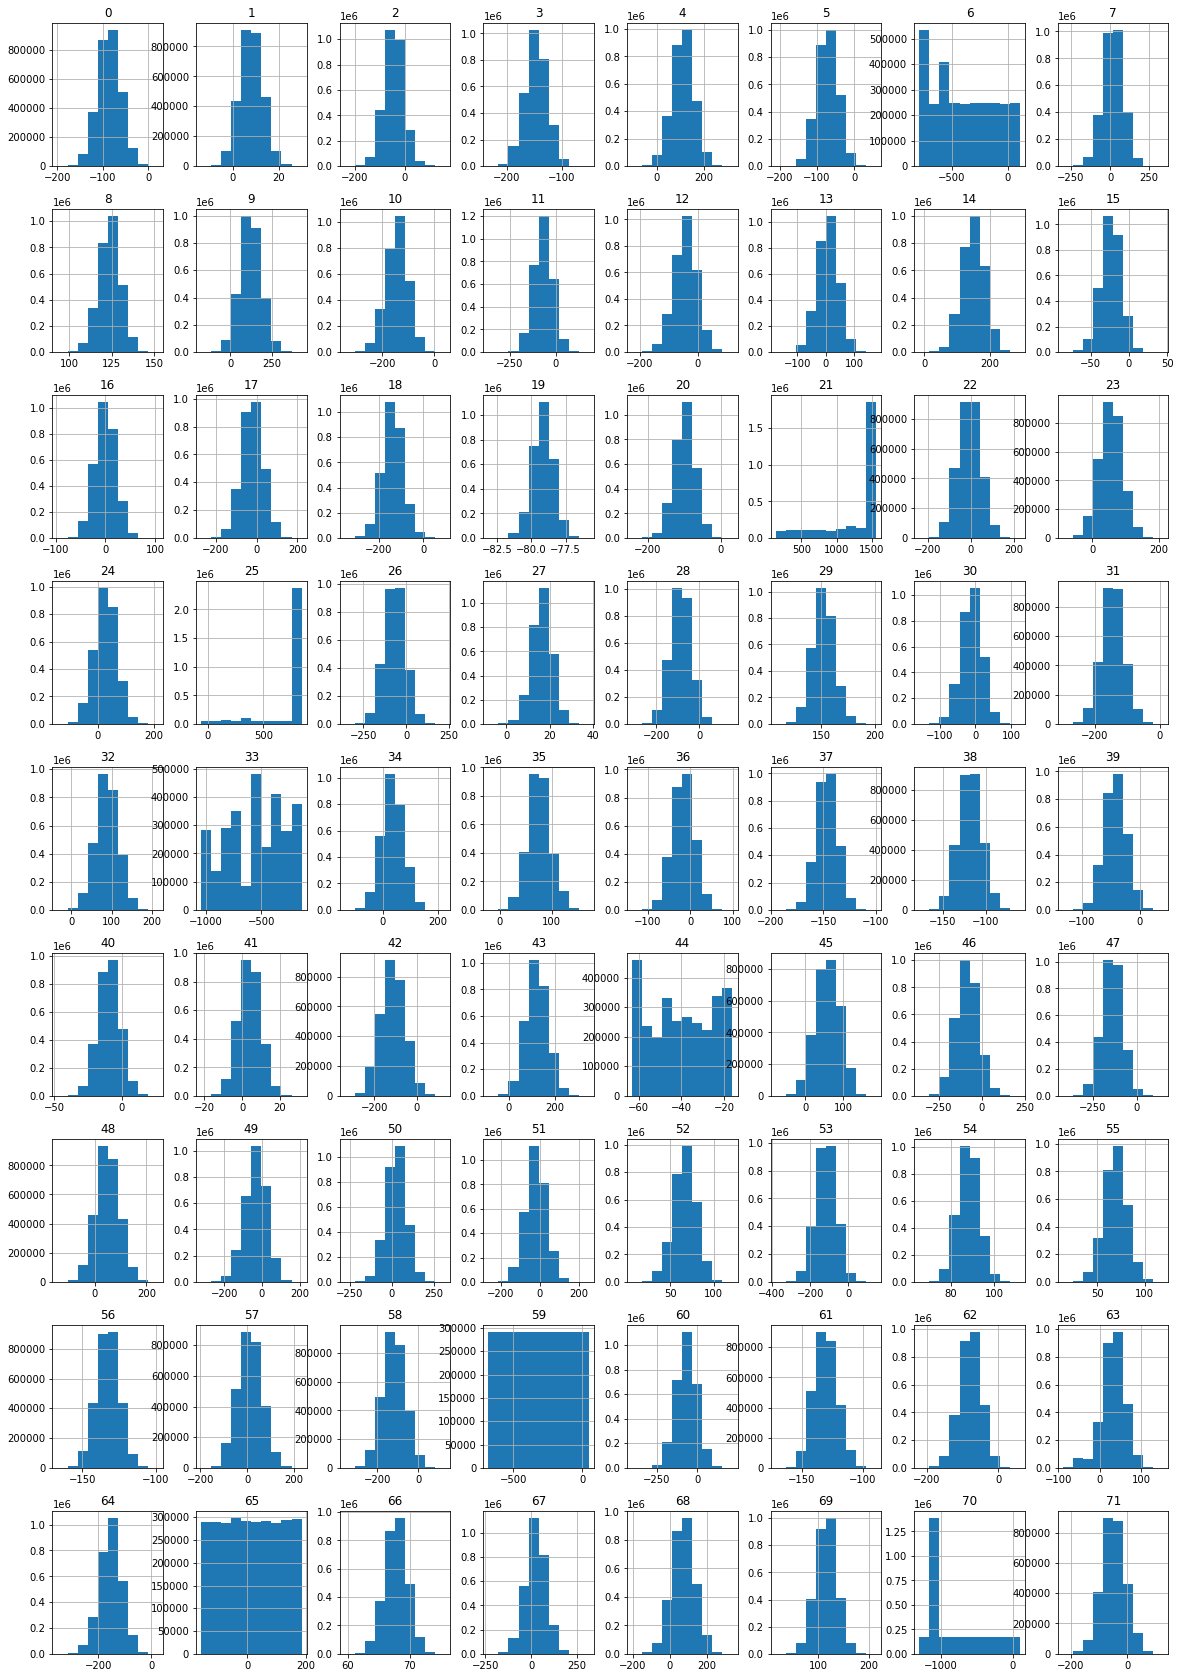

In [138]:
base_data.hist(figsize=(20, 30));

Большинство данных имеют нормальное распределение или близкое к нормальному. 
Есть несколько признаков с выбивающимися значениями: 6, 21, 25, 33, 44, 70.

Изучим основную информацию о данных в датасете train_data

In [139]:
check_data(train_data)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9  ...         63  \
Id                                                      ...              
0-query -347.360606  38.307602  109.085560   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.915900  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607820  ...  78.039764   
3-query -775.150134  79.186520  124.003100  242.650650  ...  44.515266   
4-query -321.317964  45.984676  125.941284  103.392670  ...  45.028910   

                64          65         66          67          68          69  \
Id                                                                              
0-query -155.80257 -101.965943  65.903790   34.457500   62.642094  134.763600   
1-query -151.69771   -1.638704  68.170876   25.096191   89.974976  130.589630   
2-query -169.14620   82.144186  66.008220   18.400496  212.409730  121.931470   
3-query -145.41675   93.990981  64.131350  106.061920   83.178760  118.277725   
4-query -196.09207 -117.626337  66.926220   42.456170   77.621765   92.479930   

                  70         71        Target  
Id                                             
0-query  -415.750254 -25.958572   675816-base  
1-query -1035.092211 -51.276833   366656-base  
2-query -1074.464888 -22.547178  1447819-base  
3-query -1074.464888 -19.902788  1472602-base  
4-query -1074.464888 -21.149351   717819-base  

[5 rows x 73 columns]

Количество пропусков:
0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

Количество дубликатов: 0



count        mean         std          min          25%         50%  \
0   100000.0  -85.328679   25.803845  -186.280270  -103.309147  -85.273695   
1   100000.0    7.664345    4.955651   -11.560507     4.313784    7.652854   
2   100000.0  -43.667046   39.111064  -224.896060   -69.494487  -42.830246   
3   100000.0 -146.118630   20.434841  -223.307220  -160.028520 -146.067445   
4   100000.0  111.770592   47.700958   -93.272020    79.474322  112.260100   
..       ...         ...         ...          ...          ...         ...   
67  100000.0   23.029277   55.470761  -203.746380   -14.144571   23.441363   
68  100000.0   73.412076   62.203132  -181.973820    31.685548   72.880192   
69  100000.0  115.189717   21.582238    22.598862   100.589324  115.236635   
70  100000.0 -709.761548  405.961084 -1297.871984 -1074.464888 -808.801696   
71  100000.0  -48.505704   41.215124  -209.935760   -76.478591  -48.700929   

           75%         max  
0   -67.330810   14.585236  
1    10.981191   28.917845  
2   -17.713690  128.108460  
3  -132.277745  -60.751625  
4   143.760830  301.363600  
..         ...         ...  
67   59.941065  266.493320  
68  114.469224  319.867520  
69  129.791085  201.761260  
70 -357.087323   98.768233  
71  -20.487869  126.191790  

[72 rows x 8 columns]

Тренировочный датасет train_data с размеченными данными имеет 100000 анонимизированных данных. Как и base_data содержит 72 признака и один категориальный целевой признак Target (похожие товары из base_data).  
Пропусков и дублей нет.  

Также построим гистограмму для train_data

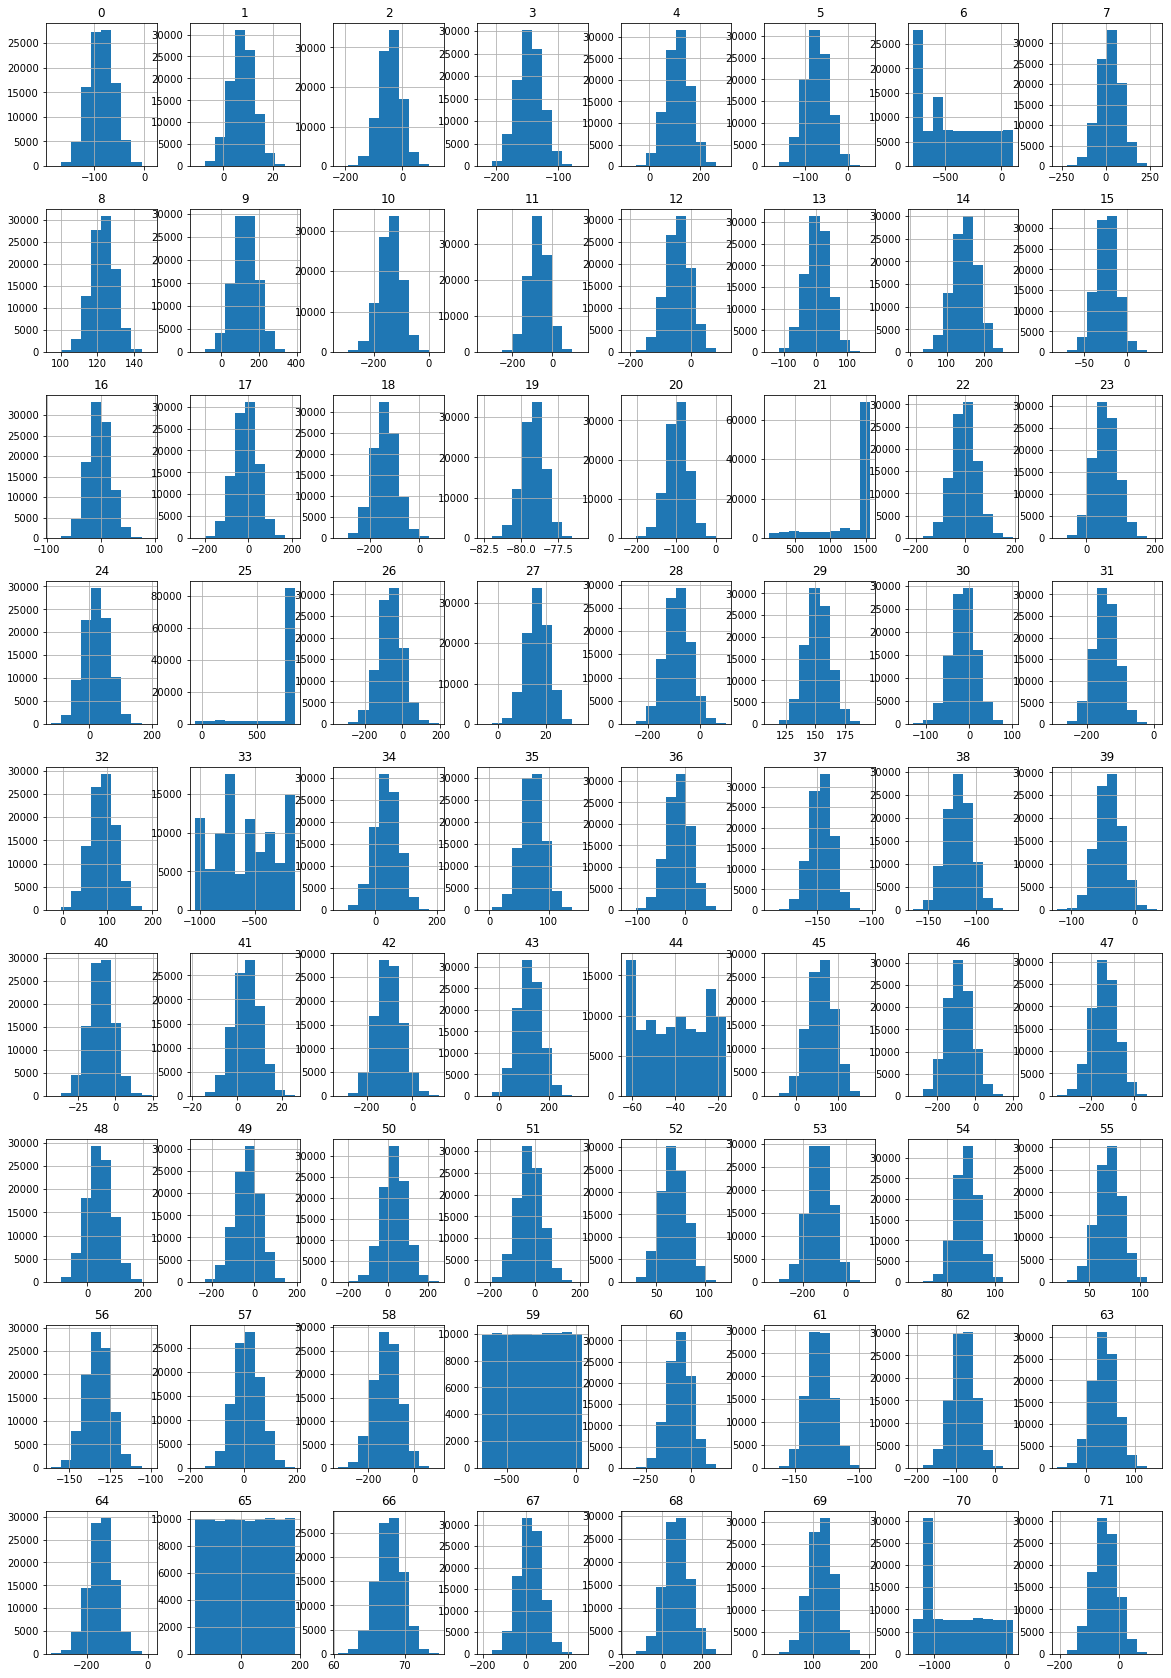

In [140]:
train_data.hist(figsize=(20, 30));

Как и в base_data большинство данных имеют нормальное распределение или близкое к нормальному.   
Есть несколько признаков с выбивающимися значениями: 6, 21, 25, 33, 44, 70.  

Изучим основную информацию о данных в датасете valid_data

In [141]:
check_data(valid_data)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  ...  \
Id                                                                        ...   
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750  ...   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998  ...   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320  ...   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730  ...   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914  ...   

                     62         63         64          65        66  \
Id                                                                    
100000-query  -75.51302  52.830902 -143.43945   59.051935  69.28224   
100001-query  -79.44183  29.185436 -168.60590  -82.872443  70.76560   
100002-query -134.79541  37.368730 -159.66231 -119.232725  67.71044   
100003-query  -77.23611  44.100494 -132.53012 -106.318982  70.88396   
100004-query -123.77025  45.635944 -134.25893   13.735359  70.61763   

                     67         68          69           70          71  
Id                                                                       
100000-query  61.927513  111.59253  115.140656 -1099.130485 -117.079360  
100001-query -65.975950   97.07716  123.391640  -744.442332  -25.009320  
100002-query  86.002060  137.63641  141.081630  -294.052271  -70.969604  
100003-query  23.577892  133.18396  143.252940  -799.363667  -89.392670  
100004-query  15.332115  154.56812  101.700640 -1171.892332 -125.307890  

[5 rows x 72 columns]

Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0



count        mean         std          min          25%         50%  \
0   100000.0  -85.302233   25.777321  -190.353330  -103.231790  -85.296745   
1   100000.0    7.669724    4.956990   -11.109877     4.292425    7.657888   
2   100000.0  -43.842474   39.138775  -217.538420   -69.680916  -43.230835   
3   100000.0 -146.119797   20.495541  -220.050890  -160.210287 -146.080365   
4   100000.0  111.635071   47.751576   -81.198990    79.101920  111.959330   
..       ...         ...         ...          ...          ...         ...   
67  100000.0   23.250779   55.403862  -210.672800   -13.863008   23.508739   
68  100000.0   73.114446   62.056224  -175.921780    31.494840   72.152398   
69  100000.0  115.196935   21.493081    25.271042   100.538862  115.280990   
70  100000.0 -709.457021  405.665764 -1297.923999 -1074.464888 -807.029697   
71  100000.0  -48.416276   41.292843  -209.935760   -76.359190  -48.670001   

           75%         max  
0   -67.422104   14.427986  
1    10.993900   27.409784  
2   -17.765821  134.859800  
3  -132.119278  -57.381890  
4   143.903735  302.065370  
..         ...         ...  
67   60.154775  251.288590  
68  114.317053  305.937530  
69  129.770215  201.599980  
70 -358.400478   98.737079  
71  -20.283335  111.831955  

[72 rows x 8 columns]

valid_data - датасет с 100000 товаров, для которых надо найти наиболее близкие товары из base_data.  
Пропусков и дубликатов нет.  

Построим гистаграмму для данных valid_data

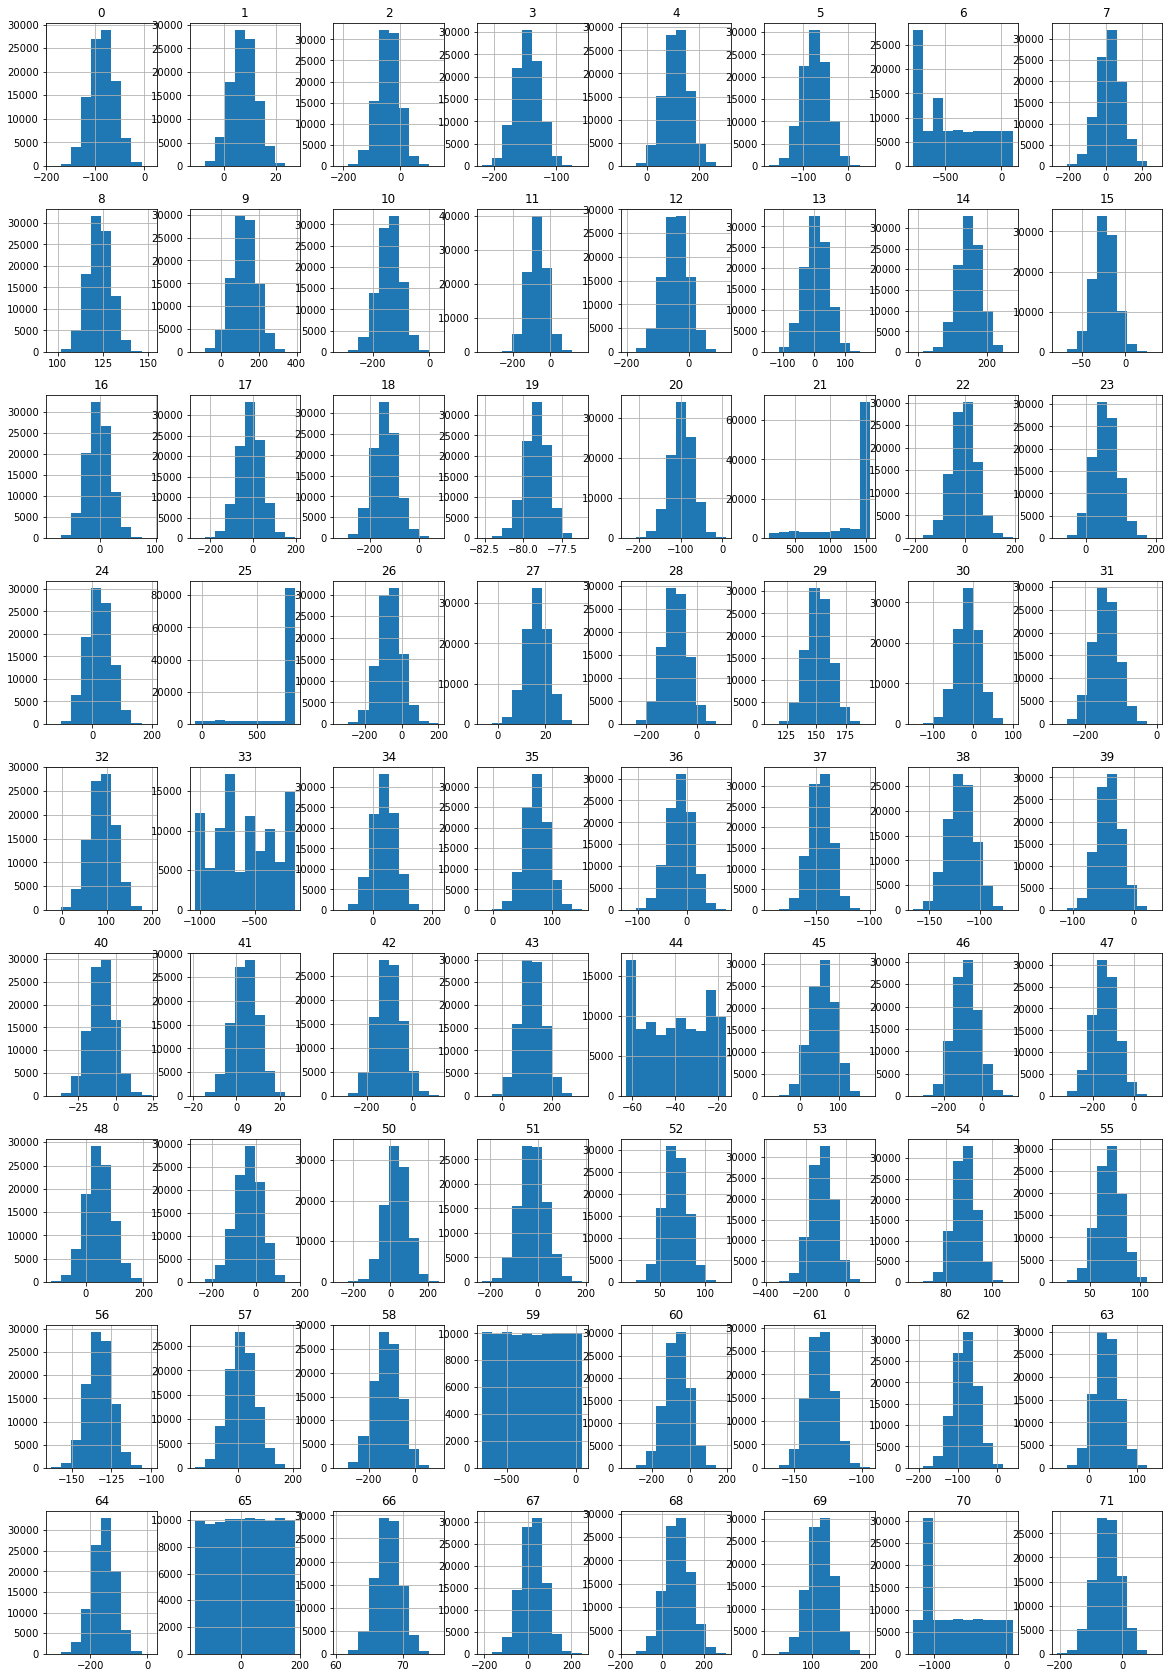

In [142]:
valid_data.hist(figsize=(20, 30));

Как и в base_data большинство данных имеют нормальное распределение или близкое к нормальному. 
Есть несколько признаков с выбивающимися значениями: 6, 21, 25, 33, 44, 70.

Изучим основную информацию о данных в датасете valid_answers_data

In [143]:
check_data(valid_answers_data)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

Количество пропусков:
Expected    0
dtype: int64

Количество дубликатов: 8498



count unique          top freq
Expected  100000  91502  210304-base    7

valid_answers_data содержит 100000 строк с правильными ответами (Expected) к датасету с товарами для поиска (даётся для оценки работы простроенной модели).  
Пропусков нет, дубликатов 8498.  

### 1.3 Исследовательский анализ данных

Дополнительно проверим корреляцию признаков в базовом датасете base_data и тренировочном - train_data.

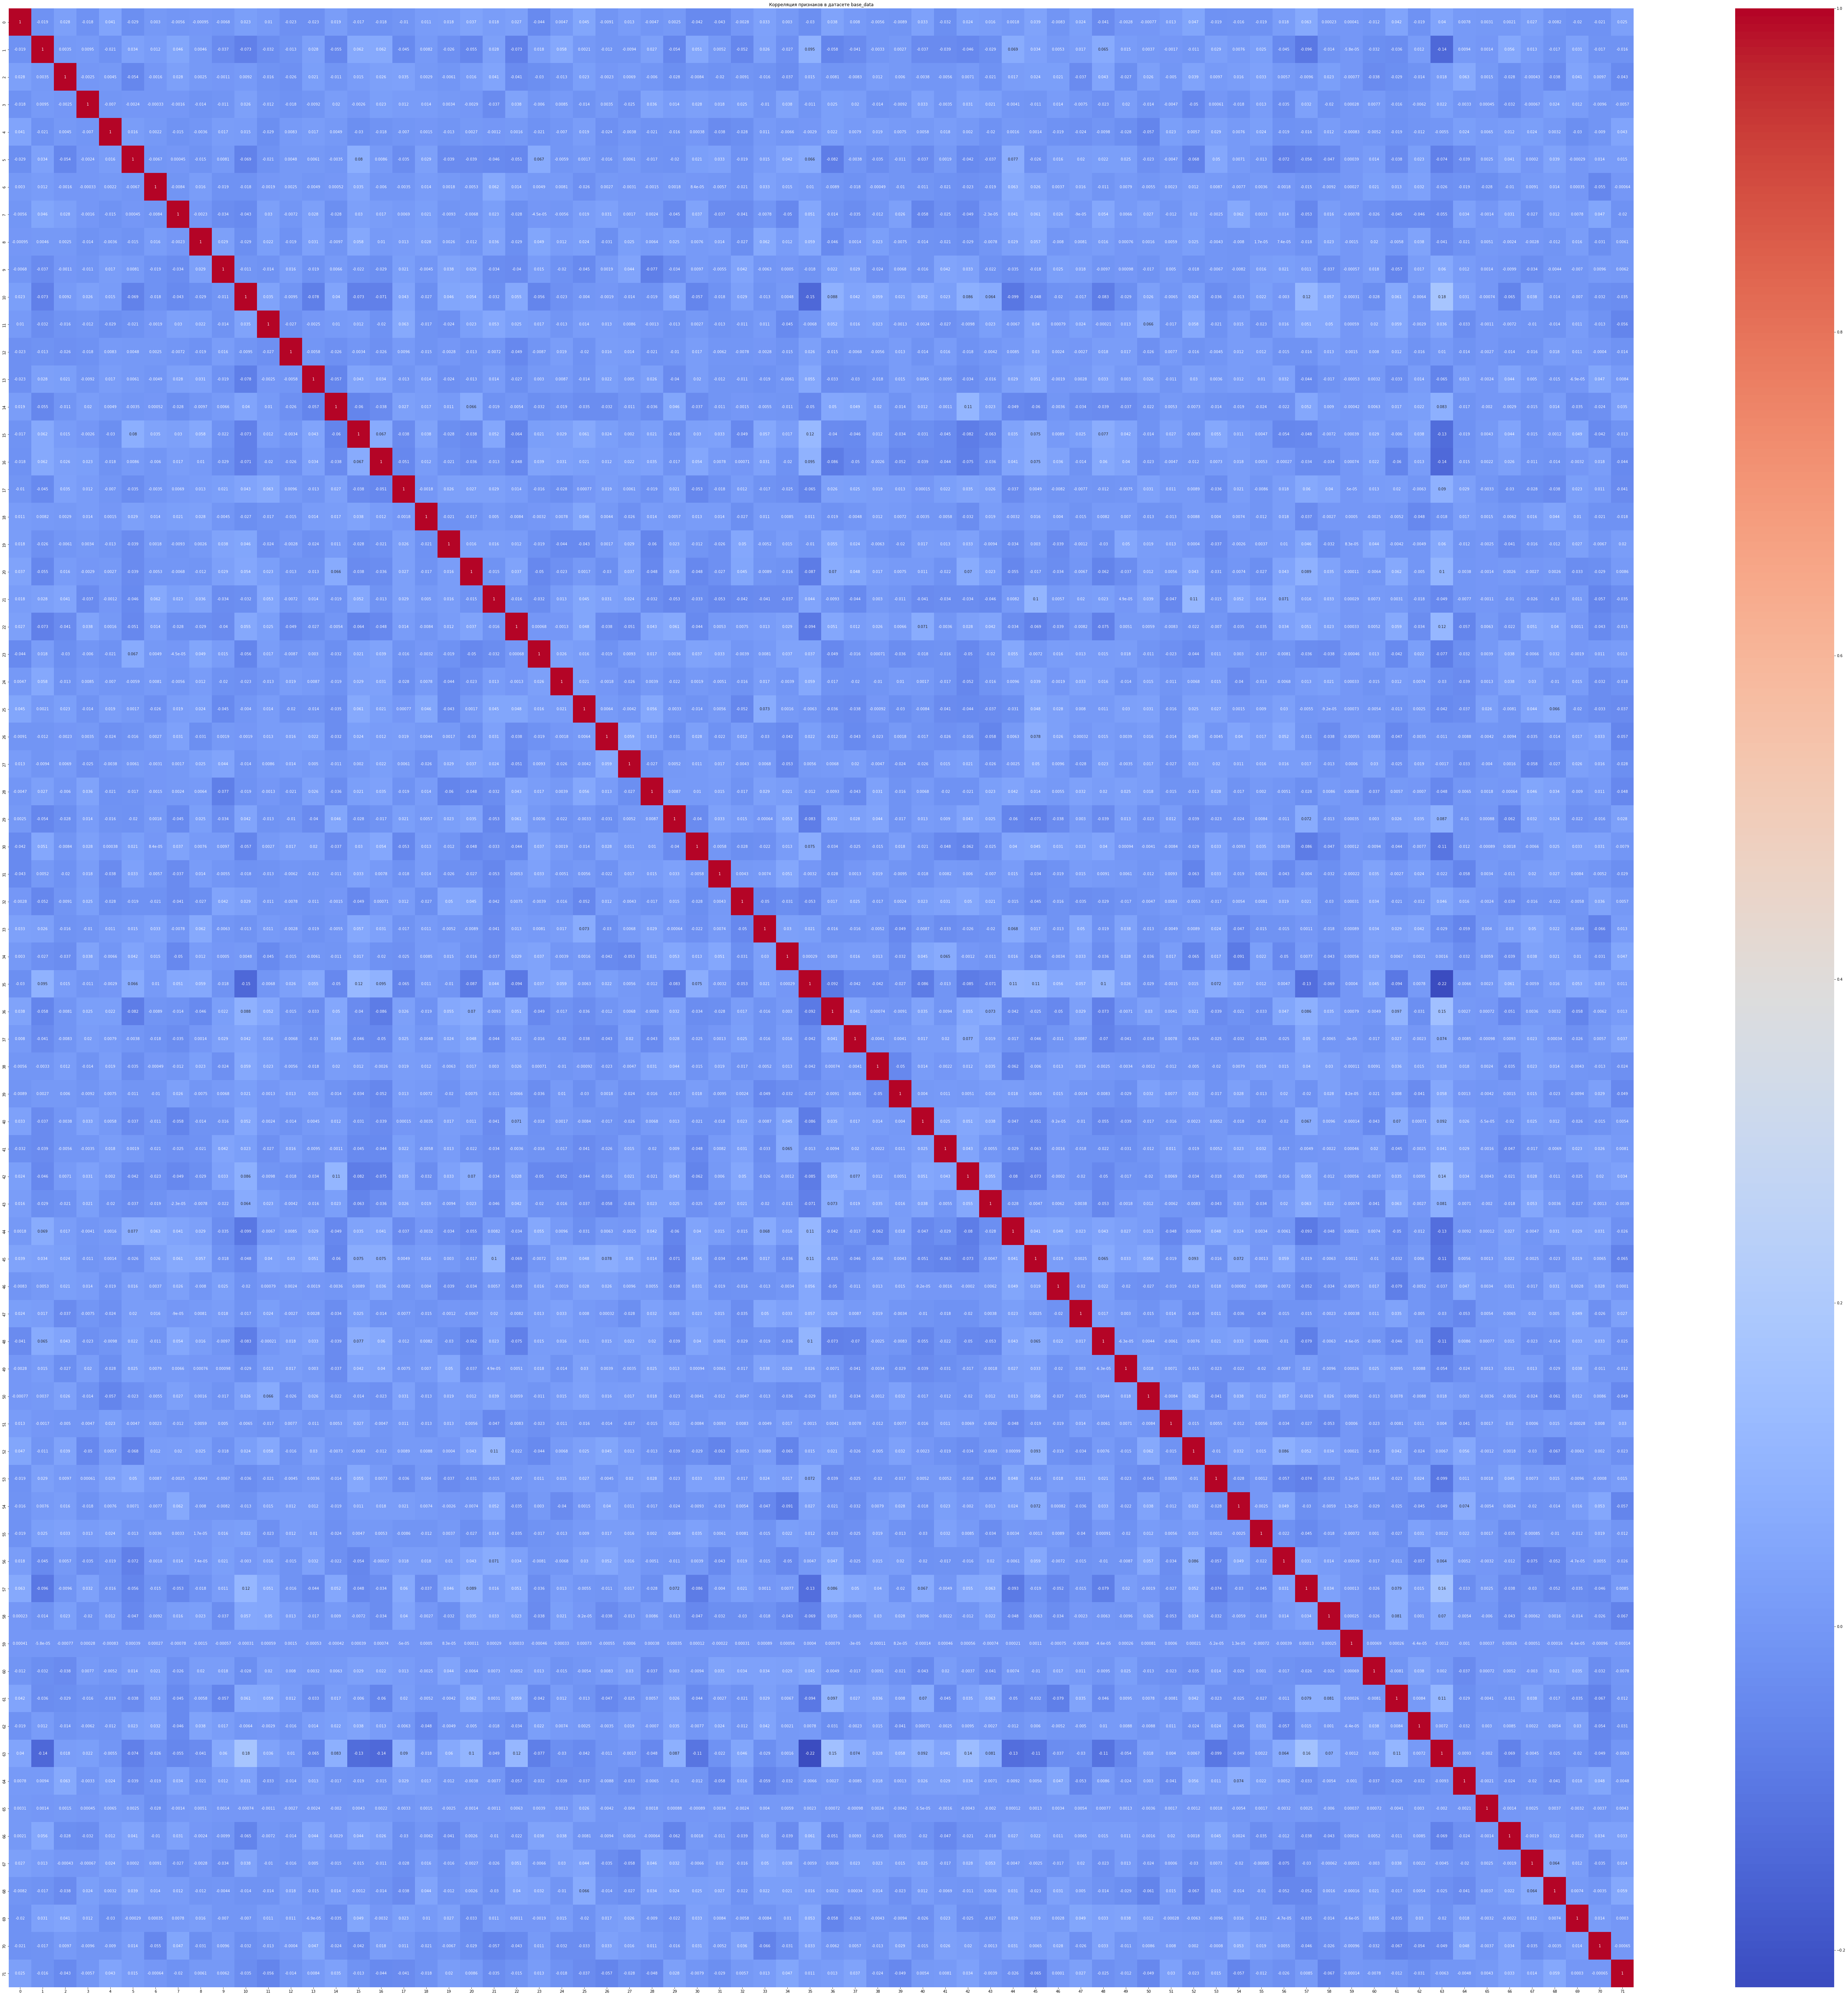

In [52]:
corr_matrix_base = base_data.corr()
plt.figure(figsize=(100, 100)) 
sns.heatmap(corr_matrix_base, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков в датасете base_data')
plt.show()

Коррелирующих признаков в base_data не обнаружено.

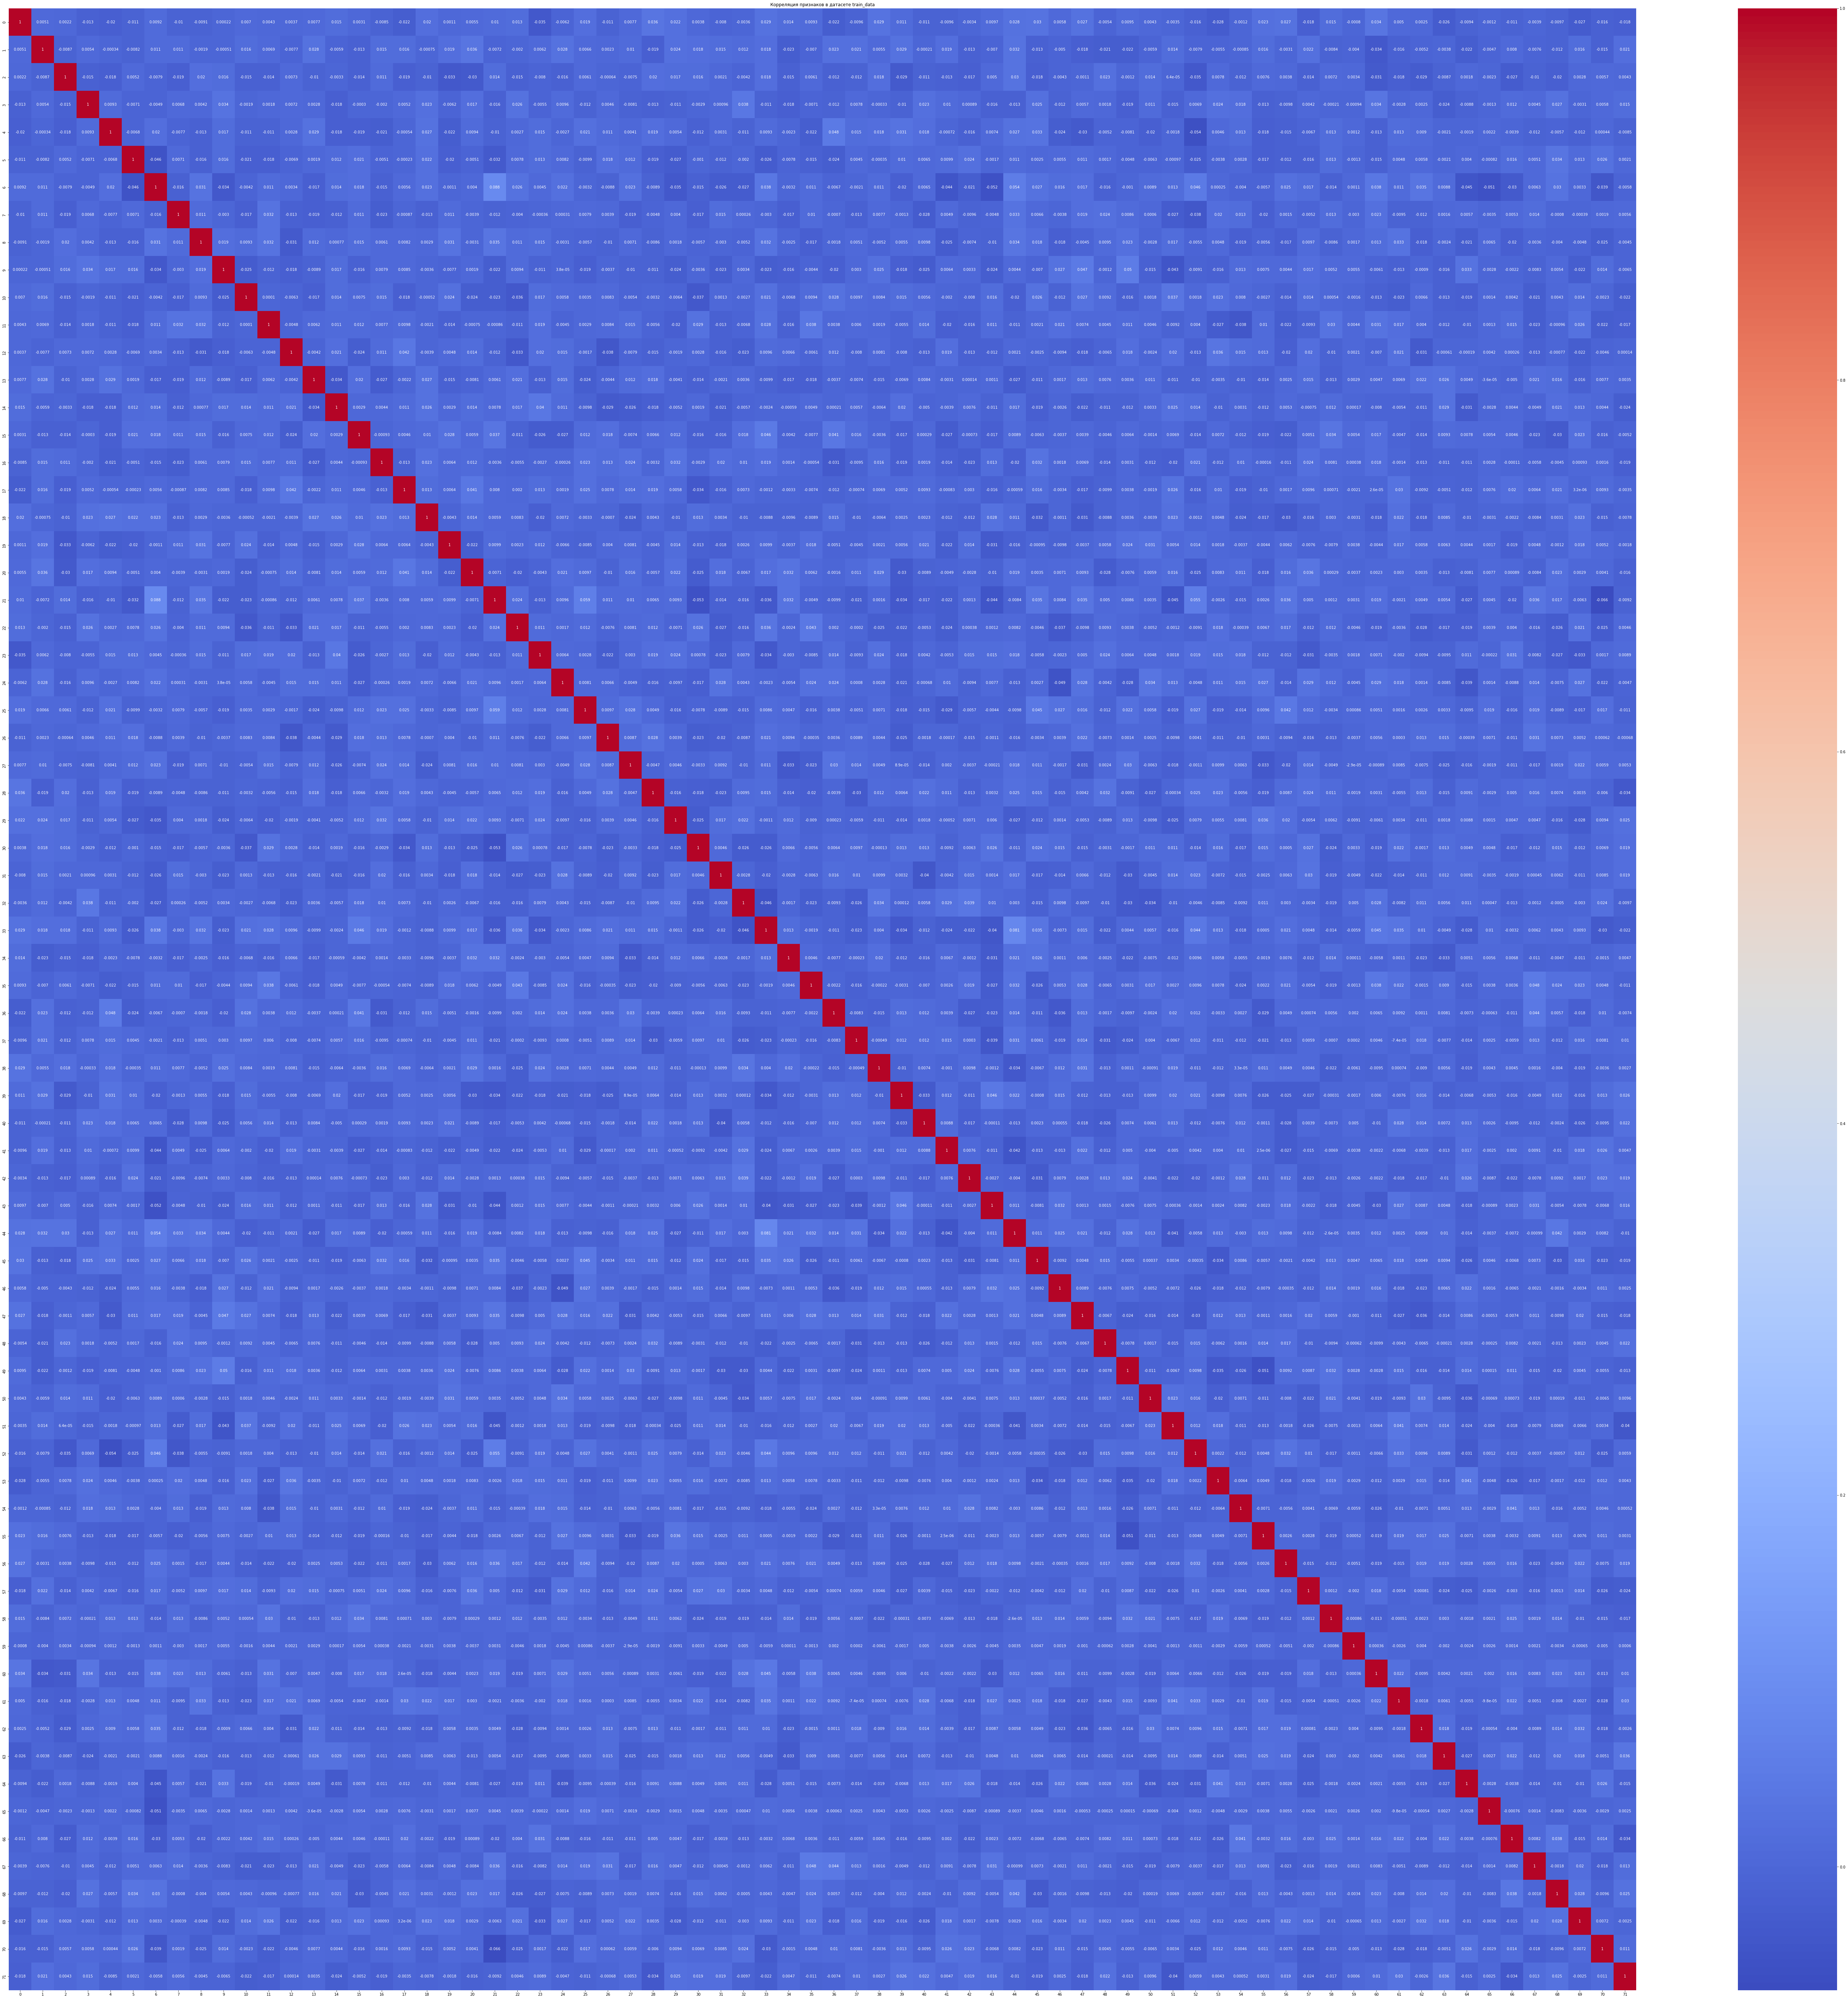

In [54]:
corr_matrix_train = train_data.corr()
plt.figure(figsize=(100, 100)) 
sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков в датасете train_data')
plt.show()

Коррелирующих признаков в train_data не обнаружено.

Удалим признаки с аномалиями: '6', '21', '25', '33', '44', '70'

In [55]:
columns_drop = ['6', '21', '25', '33', '44', '70']

base_data = base_data.drop(columns=columns_drop, axis=1)
train_data = train_data.drop(columns=columns_drop, axis=1)
valid_data = valid_data.drop(columns=columns_drop, axis=1)

In [56]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 66 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   7       float64
 7   8       float64
 8   9       float64
 9   10      float64
 10  11      float64
 11  12      float64
 12  13      float64
 13  14      float64
 14  15      float64
 15  16      float64
 16  17      float64
 17  18      float64
 18  19      float64
 19  20      float64
 20  22      float64
 21  23      float64
 22  24      float64
 23  26      float64
 24  27      float64
 25  28      float64
 26  29      float64
 27  30      float64
 28  31      float64
 29  32      float64
 30  34      float64
 31  35      float64
 32  36      float64
 33  37      float64
 34  38      float64
 35  39      float64
 36  40      float64
 37  41      float64
 38  42      float64
 39  43      float64


In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 67 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   7       100000 non-null  float64
 7   8       100000 non-null  float64
 8   9       100000 non-null  float64
 9   10      100000 non-null  float64
 10  11      100000 non-null  float64
 11  12      100000 non-null  float64
 12  13      100000 non-null  float64
 13  14      100000 non-null  float64
 14  15      100000 non-null  float64
 15  16      100000 non-null  float64
 16  17      100000 non-null  float64
 17  18      100000 non-null  float64
 18  19      100000 non-null  float64
 19  20      100000 non-null  float64
 20  22      100000 non-null  float64
 21  23  

Проверим еще раз дубликаты

In [58]:
base_data.duplicated().sum()

0

In [59]:
train_data.duplicated().sum()

0

### 1.4 Вывод

**На этапе предобработки и исследовательского анализа данных:**

1. Загрузили и изучили датасеты:

* base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, …, 100000-query), вектор признаков и id товара из base.csv, который максимально похож на него по мнению экспертов.

* validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.

* validation_answer.csv - правильные ответы к датасету с товарами для поиска (даётся для оценки работы простроенной модели).

2. Проверили количество пропущенных значений и наличие дубликатов.  
3. Проверили данные на мультиколлинеарность. Корреляций обнаружено не было.  
4. Удалили 6 столбцов с аномальными значениями: '6', '21', '25', '33', '44', '70'.

## 2. Обучение моделей

### 2.1 Решение задачи с помощью Kmeans++ и KNN

Выделим целевой признак в отдельную переменную targets, и удалим целевой признак из тренировочного датасета train_data для обучения можелей.

In [60]:
targets = train_data['Target']
train_data.drop('Target', axis=1, inplace=True)

base_data содержит довольно много данных - 2918139. 
Возьмем часть выборки для проверки алгоритма.

Алгоритм заключается в том, чтобы с помощью метода локтя определить оптимальное количество кластров, разбить выборку base_data на кластеры с помощью модели KMeans++. Далее определить для каждого товара из train_data ближайший кластер в base_data. И уже в кластере искать похожие товары с помощью NearestNeighbors.

In [ ]:
# Выбираем случайные 500000 строк из base_data
sample_size = 500000
random_indices = np.random.choice(base_data.index, size=sample_size, replace=False)
base_data_sample = base_data.loc[random_indices]

# Выполним стандартизацию признаков с использованием StandardScaler()
scaler = StandardScaler()
scaled_base_data = scaler.fit_transform(base_data_sample)
scaled_train_data = scaler.fit_transform(train_data.drop('Target', axis=1))

In [61]:
# Примененим метод локтя для определения оптимального количества кластеров

#inertia = []
#for k in range(1, 11):
    #kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    #kmeans.fit(scaled_base_data)
    #inertia.append(kmeans.inertia_)

# Построим график 

#plt.figure(figsize=(8, 6))
#plt.plot(range(1, 11), inertia, marker='o')
#plt.title('Метод локтя для определения числа кластеров')
#plt.xlabel('Количество кластеров')
#plt.ylabel('Inertia (внутрикластерная сумма квадратов расстояний)')
#plt.show()

Оптимальное количество кластеров - 5

In [5]:
optimal_k = 5

# Примененим K-Means++ с оптимальным количеством кластеров
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
base_data_sample['Cluster'] = kmeans_optimal.fit_predict(scaled_base_data)

In [8]:
# Создадим индекс base_index
base_index = {k: v for k, v in enumerate(base_data_sample.index.to_list())}

# Обучим KNN для соотнесения товаров train_data с кластерами base_data_sample
knn_classifier = NearestNeighbors(n_neighbors=1)
knn_classifier.fit(scaled_base_data)

# Найдем ближайший кластер для каждого товара в train_data
train_clusters = knn_classifier.kneighbors(scaled_train_data, return_distance=False)[:, 0]
train_clusters = base_data_sample['Cluster'].iloc[train_clusters].values

# KNN для поиска 5 ближайших соседей внутри соотнесенного кластера
knn_search = NearestNeighbors(n_neighbors=5)

# Замерим метрику качества accuracy@5
acc_knn = 0
for target, query_point, cluster in zip(train_data['Target'].values.tolist(), scaled_train_data, train_clusters):
    cluster_mask = (base_data_sample['Cluster'] == cluster)
    knn_search.fit(scaled_base_data[cluster_mask])

    _, neighbors = knn_search.kneighbors(query_point.reshape(1, -1))
    neighbors = base_data_sample[cluster_mask].index[neighbors[0]].values

    acc_knn += int(target in neighbors)

print(100 * acc_knn / len(train_data))

11.888


Получили довольно низкое значение метрики accuracy@5 - 11.888.

Попробуем решить задачу с помощью библиотеки Faiss

### 2.2 Решение задачи с помощью Faiss

### 2.2.1 Baseline

Для начала построим Baseline с Faiss FlatL2 и Faiss IVFFlat c метрикой Euclidean без регулязации числовых признаков.

**Faiss FlatL2** - простой плоский индекс, который использует эвклидово расстояние для измерения схожести между векторами. В этом случае, поиск ближайших соседей производится в пространстве, где векторы представлены точками, и измеряется расстояние между этими точками.

In [15]:
dims = base_data.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = quantizer  # Просто используем плоский индекс L2

idx_l2.train(np.ascontiguousarray(base_data).astype('float32'))
idx_l2.add(np.ascontiguousarray(base_data).astype('float32'))

# Создаем индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

In [16]:
%%time
# Поиск ближайших соседей
r, idx = idx_l2.search(np.ascontiguousarray(train_data).astype('float32'), 5)

CPU times: user 40min 49s, sys: 1min 18s, total: 42min 8s
Wall time: 22min 44s


In [17]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

29.896


**Faiss IVFFlat** в данном случае тоже использует эвклидово расстояние для измерения схожести между векторами, но имеет другую структуру, модель использует кластеризацию.
IVFFlat состоит из двух частей: квантизатор (quantizer) и индекса поиска (IVF index).  

**Квантизатор (quantizer)** используется для разделения пространства на кластеры (центроиды), и каждый кластер представляется своим центроидом. Вместо того, чтобы хранить все данные в памяти, он сохраняет центроиды в quantizer, и каждый кластер обрабатывается отдельно.

**Индекс поиска (IVF index)** используется для поиска в соответствующем кластере, что улучшает эффективность поиска в больших наборах данных.

In [18]:
dims = base_data.shape[1]
n_cells = 100
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

#Размечаем индекс, добавляем в него вектора.

idx_l2.train(np.ascontiguousarray(base_data.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(base_data.values).astype('float32'))
     
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

In [19]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(train_data.values).astype('float32'), 5)

CPU times: user 2min 10s, sys: 2.47 s, total: 2min 12s
Wall time: 1min 5s


In [20]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

11.216


Без регулязации числовых признаков, мы получаем довольно низкую метрику accuracy@5  в обоих случаях: 

* FlatL2 : 29.896
* IVFFlat: 11.216

Модель IVFFlat имеет более низкое время выполнения запроса (CPU times: user 2min 10s) по сравнению с FlatL2 (CPU times: user 40min 49s). 
Это объясняется тем, что IVFFlat эффективно использует структуру кластеризации для ускорения процесса поиска ближайших соседей. Однако качество модели падает с применением кластеризации.

### Регулязация признаков с помощью RobustScaler

In [6]:
scaler_rs = RobustScaler()
data_base_rs = scaler_rs.fit_transform(base_data)
data_train_rs = scaler_rs.transform(train_data)

Создадим датафрейм, куда будем сохранять результаты обученных моделей

In [7]:
result_data = pd.DataFrame(columns=['№', 
                                  'Model', 
                                  'Standardize',
                                  'Clusters',  
                                  'Metric', 
                                  'Accuracy@5', 
                                  'Execution Time'])

### 2.2.2 FlatL2 (Euclidean). RobustScaler()

In [25]:
dims = data_base_rs.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = quantizer  # Просто используем плоский индекс L2

idx_l2.train(np.ascontiguousarray(data_base_rs).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_rs).astype('float32'))

# Создаем индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_l2.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_rs_l2 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_rs_l2 += int(target in [base_index[r] for r in el])

print(100 * acc_rs_l2 / len(idx))
print(end_time - start_time)

70.068
10102.571192741394


In [30]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 1,
                              'Model': 'FlatL2', 
                              'Standardize': 'RobustScaler',
                              'Clusters': None, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 70.068, 
                              'Execution Time': 10102.571}, ignore_index=True)

### 2.2.3 Faiss IVFFlat FlatL2 (Euclidean). RobustScaler()

Для тестирования IVFFlat нам необходимо подобрать оптимальное количество кластеров.  
Воспользуемся KMeans и метрикой silhouette_values для определения оптимального количества кластеров.

In [11]:
X = np.ascontiguousarray(data_base_rs).astype('float32')

# Нормализация данных с использованием RobustScaler
scaler_rs = RobustScaler()
X_normalized = scaler_rs.fit_transform(X)

In [ ]:
# Пробуем разное количество кластеров
#k_values = range(2, 501)  # Начинаем с 2 кластеров, так как силуэт требует, чтобы число кластеров было хотя бы 2
#silhouette_values = []

#for k in k_values:
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #kmeans.fit(X_normalized)
    #labels = kmeans.labels_
    #silhouette_avg = silhouette_score(X_normalized, labels)
    #silhouette_values.append(silhouette_avg)

# Строим график критерия силуэта
#plt.plot(k_values, silhouette_values, marker='o')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score Method')
#plt.show()

Оптимальное количество кластеров - 100

In [13]:
optimal_clusters = 100  

In [14]:
# Используем оптимальное количество кластеров в FAISS
dims = data_base_rs.shape[1]
n_cells = optimal_clusters 
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

# Обучим и добавим в индекс
idx_l2.train(X)
idx_l2.add(X)

# Создадим индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Найдем ближайших соседей
start_time = time.time()
r, idx = idx_l2.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_rs = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_rs += int(target in [base_index[r] for r in el])

print(100 * acc_rs / len(idx))
print(end_time - start_time)

61.661
45.13977122306824


In [32]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 2,
                              'Model': 'IVFFlat', 
                              'Standardize': 'RobustScaler',
                              'Clusters': 100, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 61.661, 
                              'Execution Time': 45.13977}, ignore_index=True)

### 2.2.4 Faiss IVFFlat FlatL2 + nprobe (Euclidean). RobustScaler()Модель IVF + nprobe

Попробуем тот же IVFFlat, но с дополнительным параметром:   
 
**nprobe** (количество зондов) - это параметр, используемый в FAISS в контексте индексов IVF. Он определяет, сколько центроидов (кластеров) из индекса IVF должны быть посещены при поиске ближайших соседей. Каждый зонд представляет собой поиск ближайших соседей в одном из кластеров индекса IVF.   
  
Большее значение nprobe должно увеличить точность поиска, так как больше кластеров будет рассмотрено при поиске ближайших соседей, но это также увеличит время выполнения запроса.    
  
Пройдемся по нескольким значениям nprobe и посмотрим, как изменится точность (accuracy) и время выполнения (execution_time). Это поможет нам выбрать оптимальное значение nprobe.  

In [16]:
dims = data_base_rs.shape[1]
n_cells = optimal_clusters

nprobe_values = [1, 5, 10, 20, 30]

results = []

for nprobe in nprobe_values:
    idx_l2.nprobe = nprobe

    start_time = time.time()
    r, idx = idx_l2.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
    end_time = time.time()

    acc_rs = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc_rs += int(target in [base_index[r] for r in el])

    results.append({'nprobe': nprobe, 'accuracy': 100 * acc_rs / len(idx), 'execution_time': end_time - start_time})

# Выведем результаты
for result in results:
    print(f"nprobe: {result['nprobe']}, Accuracy@5: {result['accuracy']}, Execution Time: {result['execution_time']} seconds")

nprobe: 1, Accuracy@5: 61.661, Execution Time: 49.2422456741333 seconds
nprobe: 5, Accuracy@5: 68.72, Execution Time: 260.73467087745667 seconds
nprobe: 10, Accuracy@5: 69.453, Execution Time: 425.4469680786133 seconds
nprobe: 20, Accuracy@5: 69.783, Execution Time: 1008.0555100440979 seconds
nprobe: 30, Accuracy@5: 69.915, Execution Time: 1580.585236787796 seconds


Чем больше значение nprobe, тем выше качество поиска. В нашем случае лучший результат достигается при nprobe равное 30, Accuracy@5 - 69.915, время поиска похожих товаров 1580.5852 сек.
Время, действительно, требуется больше.

In [34]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 3,
                              'Model': 'IVFFlat + nprobe (30)', 
                              'Standardize': 'RobustScaler',
                              'Clusters': 100, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 69.915, 
                              'Execution Time': 1580.5852}, ignore_index=True)

### 2.2.5 Faiss FlatIP (Cosine). RobustScaler()

Теперь попробуем косинусную метрику схожести. До этого мы тестировали только эвклидово расстояние

In [22]:
dims = data_base_rs.shape[1]
quantizer = faiss.IndexFlatIP(dims)  # Индекс для косинусной метрики
idx_flat_ip = quantizer

idx_flat_ip.train(np.ascontiguousarray(data_base_rs).astype('float32'))
idx_flat_ip.add(np.ascontiguousarray(data_base_rs).astype('float32'))

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_flat_ip.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_cosine = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_cosine += int(target in [base_index[r] for r in el])

print(100 * acc_cosine / len(idx))
print(end_time-start_time)

66.496
988.326014995575


In [35]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 4,
                              'Model': 'FlatIP', 
                              'Standardize': 'RobustScaler',
                              'Clusters': None, 
                              'Metric': 'Cosine', 
                              'Accuracy@5': 66.496, 
                              'Execution Time': 988.3260}, ignore_index=True)

### 2.2.6 Faiss Flat (Manhattan). RobustScaler()

Проверим обычную модель Flat с Манхэттановским расстоянием

In [15]:
# Пример данных
X = np.ascontiguousarray(data_base_rs).astype('float32')

# Инициализация индекса с манхэттенским расстоянием
dims = X.shape[1]
idx_flat = faiss.IndexFlat(dims)

# Устанавливаем манхэттенскую метрику
idx_flat.metric_type = faiss.METRIC_L1

# Обучение и добавление в индекс
idx_flat.train(X)
idx_flat.add(X)

# Создаем индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_flat.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_manhattan_flat = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_manhattan_flat += int(target in [base_index[r] for r in el])

print(100 * acc_manhattan_flat / len(idx))
print(end_time - start_time)

70.488
4885.138394117355


In [36]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 5,
                              'Model': 'Flat', 
                              'Standardize': 'RobustScaler',
                              'Clusters': None, 
                              'Metric': 'Manhattan', 
                              'Accuracy@5': 70.488, 
                              'Execution Time': 4885.13839}, ignore_index=True)

### 2.2.7 Faiss IVFFlat (Cosine). RobustScaler()

Протестируем IVFFlat с косинусной метрикой схожести

In [16]:
# Использование оптимального количества кластеров в FAISS с косинусной метрикой
dims = data_base_rs.shape[1]
n_cells = optimal_clusters  # Используем оптимальное количество кластеров
quantizer = faiss.IndexFlatIP(dims)  # Индекс для косинусной метрики
idx_ivf_cosine = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)

# Обучение и добавление в индекс
idx_ivf_cosine.train(X)
idx_ivf_cosine.add(X)

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_ivf_cosine.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_cosine_ivf = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_cosine_ivf += int(target in [base_index[r] for r in el])

print(100 * acc_cosine_ivf / len(idx))
print(end_time - start_time)

59.088
39.81446313858032


In [37]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 6,
                              'Model': 'IVFFlat', 
                              'Standardize': 'RobustScaler',
                              'Clusters': 100, 
                              'Metric': 'Cosine', 
                              'Accuracy@5': 59.088, 
                              'Execution Time': 39.81446}, ignore_index=True)

### Регулязация признаков с помощью StandardScaler

Попробуем другой метод регулязации числовых признаков: StandardScaler()

In [17]:
scaler_ss = StandardScaler()
data_base_ss = scaler_ss.fit_transform(base_data)
data_train_ss = scaler_ss.transform(train_data)

Протестируем все те же модели, но уже после регулязации StandardScaler()

### 2.2.8 Faiss FlatL2 (Euclidean). StandardScaler()

In [18]:
dims = data_base_ss.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = quantizer  # Просто используем плоский индекс L2

idx_l2.train(np.ascontiguousarray(data_base_ss).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_ss).astype('float32'))

# Создаем индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_l2.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
end_time = time.time()

acc_ss_l2 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_ss_l2 += int(target in [base_index[r] for r in el])

print(100 * acc_ss_l2 / len(idx))
print(end_time - start_time)

68.895
946.7492351531982


In [38]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 7,
                              'Model': 'FlatL2', 
                              'Standardize': 'StandardScaler',
                              'Clusters': None, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 68.895, 
                              'Execution Time': 946.7492}, ignore_index=True)

### 2.2.9 Faiss IVFFlat FlatL2 (Euclidean). StandardScaler()

Определим оптимальное количество кластеров с помощью silhouette_values

In [ ]:
# X = np.ascontiguousarray(data_base_ss).astype('float32')

# Нормализация данных с использованием StandardScaler()
# scaler_ss = StandardScaler()
# X_normalized_ss = scaler_ss.fit_transform(X)

# Пробуем разное количество кластеров
# k_values = range(2, 501)
# silhouette_values = []

# for k in k_values:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    # kmeans.fit(X_normalized_ss)
    # labels = kmeans.labels_
    # silhouette_avg = silhouette_score(X_normalized_ss, labels)
    # silhouette_values.append(silhouette_avg)

# Построим график критерия силуэта
# plt.plot(k_values, silhouette_values, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score Method')
# plt.show()

Оптимальное количество кластеров тоже 100

In [19]:
optimal_clusters_ss = 100 

In [20]:
# Оптимальное количество кластеров в FAISS
dims = data_base_ss.shape[1]
n_cells = optimal_clusters_ss 
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

# Обучим и добавим в индекс
idx_l2.train(X)
idx_l2.add(X)

# Создадим индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_l2.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
end_time = time.time()

acc_ss = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_ss += int(target in [base_index[r] for r in el])

print(100 * acc_ss / len(idx))
print(end_time - start_time)

57.008
39.05762791633606


In [39]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 8,
                              'Model': 'IVFFlat', 
                              'Standardize': 'StandardScaler',
                              'Clusters': 100, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 57.008, 
                              'Execution Time': 39.0576}, ignore_index=True)

### 2.2.10 Faiss IVFFlat FlatL2 + nprobe (Euclidean). StandardScaler()

In [24]:
dims = data_base_ss.shape[1]
n_cells = optimal_clusters_ss

nprobe_values = [1, 5, 10, 20, 30] 

results = []

for nprobe in nprobe_values:
    idx_l2.nprobe = nprobe

    start_time = time.time()
    r, idx = idx_l2.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    end_time = time.time()

    acc_ss = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc_ss += int(target in [base_index[r] for r in el])

    results.append({'nprobe': nprobe, 'accuracy': 100 * acc_ss / len(idx), 'execution_time': end_time - start_time})

# Выведем результаты
for result in results:
    print(f"nprobe: {result['nprobe']}, Accuracy@5: {result['accuracy']}, Execution Time: {result['execution_time']} seconds")

nprobe: 1, Accuracy@5: 57.008, Execution Time: 97.09605765342712 seconds
nprobe: 5, Accuracy@5: 68.282, Execution Time: 472.8168330192566 seconds
nprobe: 10, Accuracy@5: 69.019, Execution Time: 2981.200938940048 seconds
nprobe: 20, Accuracy@5: 69.285, Execution Time: 5889.163608074188 seconds
nprobe: 30, Accuracy@5: 69.395, Execution Time: 6275.287161111832 seconds


In [40]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 9,
                              'Model': 'IVFFlat + nprobe (30)', 
                              'Standardize': 'StandardScaler',
                              'Clusters': 100, 
                              'Metric': 'Euclidean', 
                              'Accuracy@5': 69.395, 
                              'Execution Time': 6275.28716}, ignore_index=True)

### 2.2.11 Faiss FlatIP (Cosine). StandardScaler()

In [21]:
dims = data_base_ss.shape[1]
quantizer = faiss.IndexFlatIP(dims)  # Индекс для косинусной метрики
idx_flat_ip = quantizer

idx_flat_ip.train(np.ascontiguousarray(data_base_ss).astype('float32'))
idx_flat_ip.add(np.ascontiguousarray(data_base_ss).astype('float32'))

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_flat_ip.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
end_time = time.time()

acc_cosine = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_cosine += int(target in [base_index[r] for r in el])

print(100 * acc_cosine / len(idx))
print(end_time - start_time)

65.392
807.3947370052338


In [41]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 10,
                              'Model': 'FlatIP', 
                              'Standardize': 'StandardScaler',
                              'Clusters': None, 
                              'Metric': 'Cosine', 
                              'Accuracy@5': 65.392, 
                              'Execution Time': 807.394737}, ignore_index=True)

### 2.2.12 Faiss IVFFlat FlatIP (Cosine). StandardScaler()

In [22]:
# Используем оптимальное количество кластеров в FAISS с косинусной метрикой
dims = data_base_ss.shape[1]
n_cells = optimal_clusters_ss  # Используем оптимальное количество кластеров
quantizer = faiss.IndexFlatIP(dims)  # Индекс для косинусной метрики
idx_ivf_cosine = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)

# Обучим и добавим в индекс
idx_ivf_cosine.train(X)
idx_ivf_cosine.add(X)

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_ivf_cosine.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
end_time = time.time()

acc_cosine_ivf = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_cosine_ivf += int(target in [base_index[r] for r in el])

print(100 * acc_cosine_ivf / len(idx))
print(end_time - start_time)

58.396
92.55340886116028


In [42]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 11,
                              'Model': 'IVFFlat', 
                              'Standardize': 'StandardScaler',
                              'Clusters': 100, 
                              'Metric': 'Cosine', 
                              'Accuracy@5': 58.396, 
                              'Execution Time': 92.55341}, ignore_index=True)

### 2.2.13 Faiss Flat (Manhattan). StandardScaler()

In [23]:
X = np.ascontiguousarray(data_base_ss).astype('float32')

# Инициализация индекса с манхэттенским расстоянием
dims = X.shape[1]
idx_flat = faiss.IndexFlat(dims)

# Устанавливаем манхэттенскую метрику
idx_flat.metric_type = faiss.METRIC_L1

# Обучим и добавим в индекс
idx_flat.train(X)
idx_flat.add(X)

# Создадим индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_flat.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
end_time = time.time()

acc_manhattan_flat = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_manhattan_flat += int(target in [base_index[r] for r in el])

print(100 * acc_manhattan_flat / len(idx))
print(end_time - start_time)

70.351
11870.430675029755


In [43]:
# Добавление результатов в датафрейм
result_data = result_data.append({'№': 12,
                              'Model': 'Flat', 
                              'Standardize': 'StandardScaler',
                              'Clusters': None, 
                              'Metric': 'Manhattan', 
                              'Accuracy@5': 70.351, 
                              'Execution Time': 11870.43068}, ignore_index=True)

### 2.3 Вывод

Было протестировано множество моделей на тренировочной выборке:  

* Решение задачи с помощью Kmeans++ и KNN  
* Решение задачи с помощью Faiss:  
  
    * Baseline Faiss FlatL2 и Faiss IVFFlat c метрикой Euclidean (без регулязации числовых признаков);
  
    * Регулязация признаков с помощью RobustScaler():  

       * Faiss FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 + nprobe (Euclidean)  
       * Faiss FlatIP (Cosine)  
       * Faiss Flat (Manhattan)  
       * Faiss IVFFlat FlatIP (Cosine)  

    * Регулязация признаков с помощьюStandardScaler():  

       * Faiss FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 + nprobe (Euclidean)  
       * Faiss FlatIP (Cosine)  
       * Faiss IVFFlat FlatIP (Cosine)  
       * Faiss Flat (Manhattan)  

## 3. Анализ результатов

Выведем результаты всех протестированных моделей

In [44]:
result_data

№                  Model     Standardize Clusters     Metric  Accuracy@5  \
0    1                 FlatL2    RobustScaler     None  Euclidean      70.068   
1    2                IVFFlat    RobustScaler      100  Euclidean      61.661   
2    3  IVFFlat + nprobe (30)    RobustScaler      100  Euclidean      69.915   
3    4                 FlatIP    RobustScaler     None     Cosine      66.496   
4    5                   Flat    RobustScaler     None  Manhattan      70.488   
5    6                IVFFlat    RobustScaler      100     Cosine      59.088   
6    7                 FlatL2  StandardScaler     None  Euclidean      68.895   
7    8                IVFFlat  StandardScaler      100  Euclidean      57.008   
8    9  IVFFlat + nprobe (30)  StandardScaler      100  Euclidean      69.395   
9   10                 FlatIP  StandardScaler     None     Cosine      65.392   
10  11                IVFFlat  StandardScaler      100     Cosine      58.396   
11  12                   Flat  StandardScaler     None  Manhattan      70.351   

    Execution Time  
0     10102.571000  
1        45.139770  
2      1580.585200  
3       988.326000  
4      4885.138390  
5        39.814460  
6       946.749200  
7        39.057600  
8      6275.287160  
9       807.394737  
10       92.553410  
11    11870.430680

### 3.1 Вывод

Плоские модели без кластеризации дают наилучший результат (Accuracy@5): 

1. Faiss Flat (Manhattan) с регулязацией RobustScaler: 70.488  
2. Faiss Flat (Manhattan) с регулязацией StandardScaler: 70.351  
3. FlatL2 (Euclidean) с регулязацией RobustScaler: 70.068

Однако эти модели требуют больше времени для поиска похожих товаров.

Если очень важен критерий времени, можно использовать модели Faiss IVFFlat, основанные на кластеризации, лучшие результаты были получены при добавлении параметра nprobe:

1. IVFFlat + nprobe (Euclidean) с регулязацией RobustScaler: 69.915  
2. IVFFlat + nprobe (Euclidean) с регулязациейStandardScaler: 69.395  

Думаю, если продолжить тесты с поиском n_cells (оптимального количества кластеров), nprobe и другими параметрами, можно добиться более высокого значения метрики Accuracy@5:  
   
* quantizer_trainsize - размер обучающего множества для квантизатора.  
* by_residual - флаг, указывающий, следует ли сжимать данные к квантизатору относительно центроидов.  
* max_codes - максимальное количество кодов в индексе (размер словаря для квантизатора).  
* code_size - размер кода для каждого вектора в индексе.  
* polysemous_ht - количество таблиц для полисемии (это многозначность, когда в одном кластере несколько векторов).  

## 4. Обучение лучшей модели и предсказание на тестовой выборке

Теперь для всех товаров из тестовой выборки valid_data (validation.csv) найдем 5 вариантов наиболее похожих товаров из базового набора base_data (base.csv).  

В качестве модели будем использовать **Faiss Flat (Manhattan) с регулязацией RobustScaler()**, так как именно на ней были получены лучшие результаты на тренировочной выборке.

Замерим качество модели с помощью метрики  **accuracy@5**, опираясь на ответы в датасете **valid_answers_data('Expected')**.

In [46]:
scaler_rs = RobustScaler()
data_base_rs = scaler_rs.fit_transform(base_data)
data_valid_rs = scaler_rs.transform(valid_data)

In [48]:
X = np.ascontiguousarray(data_base_rs).astype('float32')

# Инициализация индекса с манхэттенским расстоянием
dims = X.shape[1]
idx_flat = faiss.IndexFlat(dims)

# Устанавим манхэттенскую метрику
idx_flat.metric_type = faiss.METRIC_L1

# Обучим и добавим в индекс
idx_flat.train(X)
idx_flat.add(X)

# Создадим индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_flat.search(np.ascontiguousarray(data_valid_rs).astype('float32'), 5)
end_time = time.time()

# Вычислим accuracy@5
acc_manhattan_flat = 0
for target, el in zip(valid_answers_data['Expected'].values.tolist(), idx.tolist()):
    acc_manhattan_flat += int(target in [base_index[r] for r in el])

print(100 * acc_manhattan_flat / len(idx))
print(end_time - start_time)

70.335
4636.75213098526


Получили довольно высокий accuracy@5 - 70.335, что говорит о хорошем качестве модели, ее точности в предсказании похожих товаров (примерно 3-4 товара из 5 предсказываются верно).

## 5. Вывод

1. На этапе предобработки и исследовательского анализа данных:

* Загрузили и изучили датасеты:  
    * base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

    * train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, …, 100000-query), вектор признаков и id товара из base.csv, который максимально похож на него по мнению экспертов.

    * validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.

    * validation_answer.csv - правильные ответы к датасету с товарами для поиска (даётся для оценки работы простроенной модели).

* Проверили количество пропущенных значений и наличие дубликатов.  
* Проверили данные на мультиколлинеарность. Корреляций обнаружено не было.  
* Удалили 6 столбцов с аномальными значениями: '6', '21', '25', '33', '44', '70'.  

2. На этапе обучения моделей:

Было протестировано множество моделей на тренировочной выборке:  

* Решение задачи с помощью Kmeans++ и KNN  
* Решение задачи с помощью Faiss:  
  
    * Baseline Faiss FlatL2 и Faiss IVFFlat c метрикой Euclidean (без регулязации числовых признаков);
  
    * Регулязация признаков с помощью RobustScaler():  

       * Faiss FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 + nprobe (Euclidean)  
       * Faiss FlatIP (Cosine)  
       * Faiss Flat (Manhattan)  
       * Faiss IVFFlat FlatIP (Cosine)  

    * Регулязация признаков с помощьюStandardScaler():  

       * Faiss FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 (Euclidean)  
       * Faiss IVFFlat FlatL2 + nprobe (Euclidean)  
       * Faiss FlatIP (Cosine)  
       * Faiss IVFFlat FlatIP (Cosine)  
       * Faiss Flat (Manhattan)  

3. На этапе анализа результатов:

Увидели, что плоские модели без кластеризации дают наилучший результат (Accuracy@5): 

* Faiss Flat (Manhattan) с регулязацией RobustScaler: 70.488  
* Faiss Flat (Manhattan) с регулязацией StandardScaler: 70.351  
* FlatL2 (Euclidean) с регулязацией RobustScaler: 70.068

Однако эти модели требуют больше времени для поиска похожих товаров.

Если очень важен критерий времени, можно использовать модели Faiss IVFFlat, основанные на кластеризации, лучшие результаты были получены при добавлении параметра nprobe:

* IVFFlat + nprobe (Euclidean) с регулязацией RobustScaler: 69.915  
* IVFFlat + nprobe (Euclidean) с регулязациейStandardScaler: 69.395    

4. Выбрали лучшую модель: Faiss Flat (Manhattan) с регулязацией RobustScaler, обучили ее на тестовой выборке valid_data и нашли топ-5 наиболее похожих товаров из базового набора base_data.

Получили довольно высокий accuracy@5 - 70.335, что говорит о хорошем качестве модели, ее точности в предсказании похожих товаров (примерно 3-4 товара из 5 предсказываются верно).

## 6. Что можно добавить, улучшить в проекте

Хотелось попробовать, реализовать, но не хватило времени

**1. Завернуть все модели Faiss и  сохранение результатов в таблицу в функцию, так как многое в коде повторяется и легко запутаться, ошибиться**

**2. Попробовать разбить кластеры на подкластеры, так как это может улучшить качество алгоритма. Это может быть осуществлено путем вложенного использования алгоритма кластеризации внутри каждого кластера.**

Можно попробовать внедрить второй уровень кластеризации для каждого кластера, найденного на первом уровне.

1. Используем KMeans для общей кластеризации данных и поиска оптимального количества кластеров.
2. Для каждого кластера, найденного на первом уровне, повторить шаги 3-5.
3. Использовать FAISS и IndexIVFFlat для обучения и поиска по каждому подкластеру.
4. Найти оптимальное количество подкластеров внутри каждого кластера на втором уровне.
5. Использовать KMeans для внутренней кластеризации каждого кластера на первом уровне.

In [ ]:
# Индекс base_index
base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# FAISS для второго уровня кластеризации
for cluster_label in range(optimal_clusters):
    # Выбираем только данные, принадлежащие текущему кластеру
    cluster_data = X_normalized[cluster_labels == cluster_label]

    # Пробуем разное количество подкластеров
    k_values_sub = range(2, 101)
    silhouette_values_sub = []

    for k_sub in k_values_sub:
        kmeans_sub = KMeans(n_clusters=k_sub, random_state=42)
        kmeans_sub.fit(cluster_data)
        labels_sub = kmeans_sub.labels_
        silhouette_avg_sub = silhouette_score(cluster_data, labels_sub)
        silhouette_values_sub.append(silhouette_avg_sub)

    # Оптимальное количество подкластеров с использованием метода локтя
    optimal_clusters_sub = 

    # FAISS для второго уровня
for cluster_label in range(optimal_clusters):
    # Выбираем только данные, принадлежащие текущему кластеру
    cluster_data = X_normalized[cluster_labels == cluster_label]

    # Пробуем разное количество подкластеров
    k_values_sub = range(2, 101)
    silhouette_values_sub = []

    for k_sub in k_values_sub:
        kmeans_sub = KMeans(n_clusters=k_sub, random_state=42)
        kmeans_sub.fit(cluster_data)
        labels_sub = kmeans_sub.labels_
        silhouette_avg_sub = silhouette_score(cluster_data, labels_sub)
        silhouette_values_sub.append(silhouette_avg_sub)
        
        # Оптимальное количество подкластеров с использованием метода локтя
    optimal_clusters_sub =  

    # FAISS для второго уровня
    dims_sub = cluster_data.shape[1]
    n_cells_sub = optimal_clusters_sub
    quantizer_sub = faiss.IndexFlatL2(dims_sub)
    idx_l2_sub = faiss.IndexIVFFlat(quantizer_sub, dims_sub, n_cells_sub)

    # Обучение и добавление в индекс
    idx_l2_sub.train(cluster_data)
    idx_l2_sub.add(cluster_data)

    # Создаем индекс base_index_sub
    base_index_sub = {k: v for k, v in enumerate(cluster_data.index.to_list())}

    # Поиск ближайших соседей
    start_time = time.time()
    r_sub, idx_sub = idx_l2_sub.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
    end_time = time.time()

    # Вычисление точности
    acc_rs_sub = 0

    for target, el in zip(targets.values.tolist(), idx_sub.tolist()):
        acc_rs_sub += int(target in [base_index_sub[r] for r in el])

    print(100 * acc_rs_sub / len(idx_sub))
    print(end_time - start_time)

**3. Протестировать IVFFlat с манхэттенским расстоянием**  
Ядро перезагружается из-за нехватки памяти

In [ ]:
X = np.ascontiguousarray(data_base_rs).astype('float32')

dims = data_base_rs.shape[1]
n_cells = optimal_clusters  # Используем оптимальное количество кластеров
quantizer = faiss.IndexFlat(dims)  # Индекс для манхэттенского расстояния
idx_ivf_manhattan = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L1)

idx_ivf_manhattan.train(X)
idx_ivf_manhattan.add(X)

base_index = {k: v for k, v in enumerate(base_data.index.to_list())}

# Поиск ближайших соседей
start_time = time.time()
r, idx = idx_ivf_manhattan.search(np.ascontiguousarray(data_train_rs).astype('float32'), 5)
end_time = time.time()

acc_manhattan_ivf = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_manhattan_ivf += int(target in [base_index[r] for r in el])

print(100 * acc_manhattan_ivf / len(idx))
print(end_time - start_time)

**4. Продолжить тесты с другими параметрами:**  
   
* quantizer_trainsize - размер обучающего множества для квантизатора.  
* by_residual - флаг, указывающий, следует ли сжимать данные к квантизатору относительно центроидов.  
* max_codes - максимальное количество кодов в индексе (размер словаря для квантизатора).  
* code_size - размер кода для каждого вектора в индексе.  
* polysemous_ht - количество таблиц для полисемии (это многозначность, когда в одном кластере несколько векторов).**